In [11]:
#!pip install rasterio
#!pip install pyspatialml

"""
In order to run this notebook, please ensure that 
you start by installing the 
necessary libraries into your python environment, 
preferably in jupyter notebooks.
The usable libraries are listed below, this will 
ensure that all processes run perfectly without fail, 
notably, please intall the pyspatial libraries 
with some functionalities of handling geotiffs/raster datasets.

"""

In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6.5)

In [ ]:
"""
This notebook uses machine learning to 
predict/estimate yields of crops and also generate 
crop mask maps using 
machine learning specifically Random Forest method. 
The general process/pattern include the following

Extracting data points
Training your model and testing it
Predicting the outputs i.e crop masks or yield estimation
"""

In [ ]:
"""
Ensure that you you read your CSV file as shown below. 
The CSV files need to extract the satellite imagery values and mutate 
the columns that will be used to train your model. 
Preferably, you can run the process of extraction in R using the following 
code. Ensure proper libraries are also installed in your short R code.
dt <- sentinel %>%
  extract(y = samples) %>%
  as.data.frame %>%
  mutate(yield = samples$Type_3)
dt

"""

In [12]:
import geopandas as gpd

# Read the shapefile
# gdf = gpd.read_file("AUS_GEDI_UPDATED.shp")
gdf = pd.read_csv("predicted_yield_data_extacted_2.csv")

# Print the first few rows of the GeoDataFrame
print(gdf.tail())

          B4      B3      B2      B5      B8     yield
2997  2381.0  2204.5  2233.5  2626.0  3427.0  1.218750
2998  2170.5  1978.0  2029.0  2427.0  3123.0  4.450625
2999  2054.0  1968.0  1990.0  2286.0  3398.0  1.502500
3000  2705.5  2249.5  2212.0  2950.0  3654.5  1.157500
3001  2402.5  2097.0  2077.0  2670.0  3587.0  2.130000


In [13]:
"""
Read the CSV as a dataframe, ofcourse not mandatory though
"""
df1 = pd.DataFrame(gdf)
df1.head()

,B4,B3,B2,B5,B8,yield
0,2419.5000,2187.0,2194.5,2655.5,3344.0,0.050625
1,2.8275,2008.5,2075.0,2387.5,3039.5,0.104375
2,2234.0000,2039.5,2101.5,2486.5,3187.5,0.126250
3,2081.5000,1981.5,2054.5,2311.0,3076.5,0.143125
4,2109.0000,1964.0,2001.0,2325.0,3025.0,0.155625


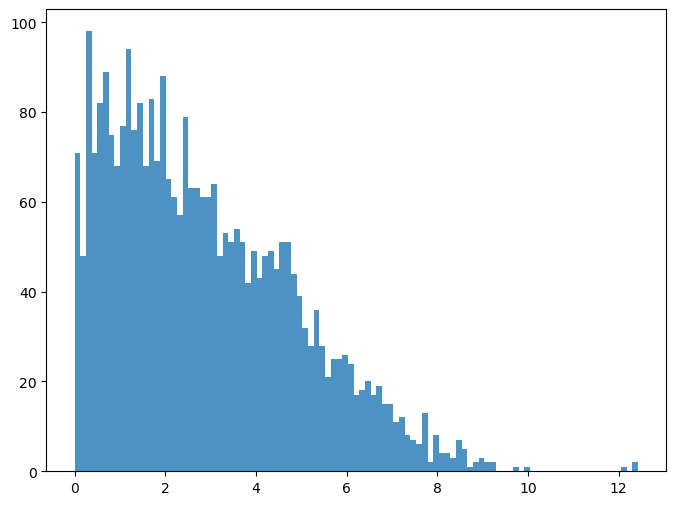

In [14]:
"""
Plotting a histogram of the crop cuts data in Mg/ha as collected from the field. 

"""
predictors =  df1
bins = np.linspace(min(predictors['yield']),max(predictors['yield']),100)
plt.hist((predictors['yield']),bins,alpha=0.8);

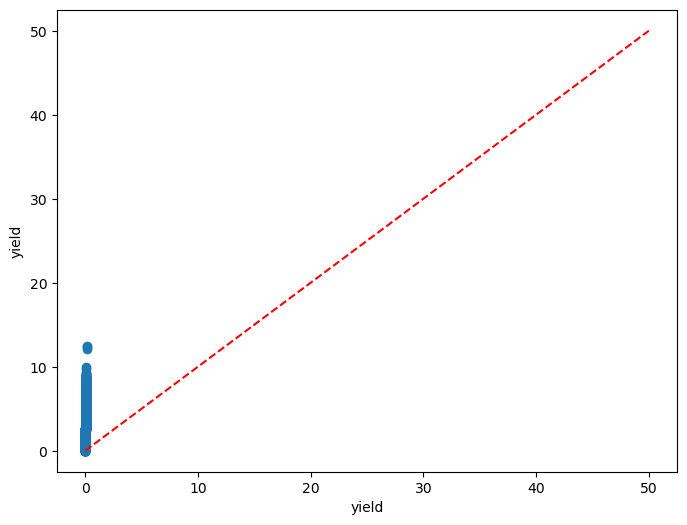

In [15]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(predictors['yield']/100,predictors['yield'])
plt.xlabel('yield')
plt.ylabel('yield')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [17]:
"""
fit the values/predictors i.e independent variables and dependent variables.
The numbers represent column indexes that represent the ind vs dep variables. 
Y will always be data collected from the field
"""
X = predictors.iloc[:,[0,1,2,3,4]].values

Y = predictors.iloc[:,5:6].values
feat = predictors.iloc[:,[0,1,2,3,4]].columns.values
feat
Y
# Y.shape
# X.shape

array([[0.050625],
       [0.104375],
       [0.12625 ],
       ...,
       [1.5025  ],
       [1.1575  ],
       [2.13    ]])

In [18]:
"""
subdiving your samples into training and testing samples, 
test size is 0.5 represent training with 50% data and testing 
the model with another 50% of the data. Ideally, ML models are 
trained by 0.7 size of the samples for most models
"""
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)
y_test

array([1.413125, 3.0275  , 4.6525  , ..., 0.75    , 2.045625, 3.9925  ])

In [19]:
"""
Calling an RF model and orinting the parameters, 
these parameters can be passed into the RF model
"""

rf = RandomForestRegressor(random_state = 42)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [20]:
"""
Calling an RF model in preparation for 
predcition and prints the fit between training datasets.
.fit(X_train, Y_train): This is a method call on the rfReg object. The .fit() 
method is used to train the Random Forest 
regression model on your training data. 
Here's what the arguments mean:

X_train: This should be a 2D array or 
DataFrame containing the feature predictors 
(input variables) for your training data. 
Each row represents a data point, 
and each column represents a different feature.
Y_train: This should be a 1D array or 
Series containing the target variable 
(the variable you want to predict) 
for your training data. It corresponds to the 
actual values or labels you're trying 
to predict based on the features in X_train.

When you call .fit(X_train, Y_train), 
the Random Forest regression model 
learns the underlying patterns and 
relationships in your training data 
to make predictions on new, unseen data. 
The model builds multiple decision trees (the "forest") 
and combines their predictions to produce a regression result.
"""

rfReg = RandomForestRegressor(min_samples_leaf=40, oob_score=True)
rfReg.fit(X_train, Y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['train']
dic_pred['test'] = rfReg.predict(X_test)
dic_pred['test']
pearsonr_all = [pearsonr(dic_pred['train'],Y_train)[1],pearsonr(dic_pred['test'],Y_test)[1]]
pearsonr_all

/var/folders/mf/0lb_7jld1p54p_x83sc_5r280000gn/T/ipykernel_75476/3946089473.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfReg.fit(X_train, Y_train);


[2.2947913595182273e-106, 3.6728290710318276e-59]

In [21]:
"""
typically refers to the out-of-bag (OOB) 
score of a random forest regression model in a 
programming context, often using 
Python's scikit-learn library or a similar machine learning framework.

In random forest regression, the OOB score is a measure of the model's 
performance on unseen data. It is computed using the data points that 
were not included in the bootstrapped training sets 
for individual decision trees within the random forest. These OOB data 
points can be seen as a form of cross-validation within the ensemble model.

The OOB score provides an estimate of 
how well the random forest model is 
likely to perform on new, unseen data. 
It is a useful metric for assessing 
the model's generalization ability 
without the need for a separate validation dataset.

In this case, an OOB score of approximately 
0.188 suggests that the random forest 
regression model has a relatively low 
level of accuracy when making predictions on unseen data. 
OOB scores typically range from 0 to 1, 
with higher values indicating better predictive performance. 
Therefore, a lower OOB score implies 
that the model may not be fitting the data well or may require 
further optimization.

"""

rfReg.oob_score_

0.1879241617456956

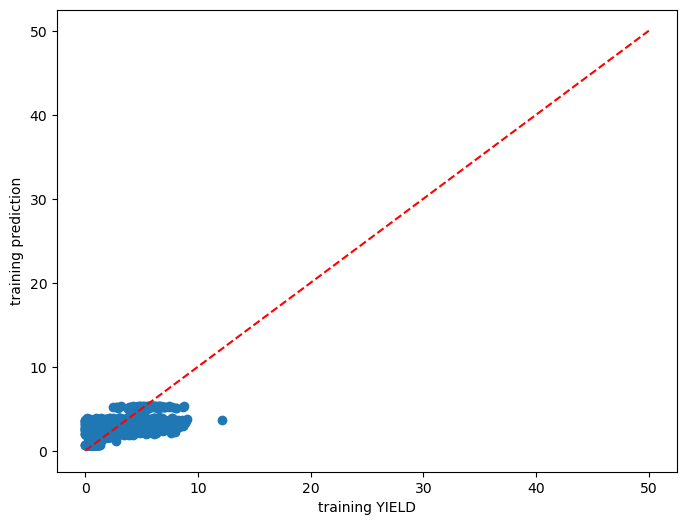

In [22]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_train,dic_pred['train'])
plt.xlabel('training YIELD')
plt.ylabel('training prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

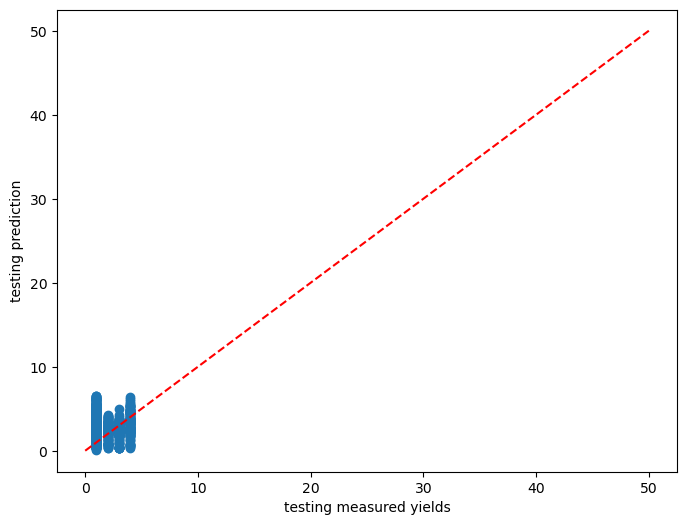

In [56]:
plt.rcParams["figure.figsize"] = (8,6)
plt.scatter(y_test,dic_pred['test'])
plt.xlabel('testing measured yields')
plt.ylabel('testing prediction')
ident = [0, 50]
plt.plot(ident,ident,'r--')

In [24]:
"""
A model outputting model parameters importance, 
this assists in eliminating redundancy in the input datasets
A visual plot follows below
"""

impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)]
ind = np.argsort(impt[0])
ind

array([3, 1, 2, 4, 0])

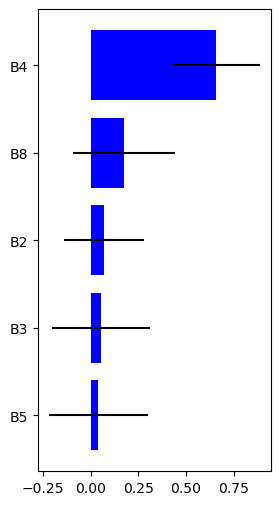

In [25]:
plt.rcParams["figure.figsize"] = (3,6)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

In [26]:
"""
This functio tried to aid in picking the 
best parameters for a random forest model to be 
used in estimation, and typically to be 
fed in the training model as model parameters. 
Please notice the out put print format
"""


pipeline = Pipeline([('rf',RandomForestRegressor())])

parameters = {
        'rf__max_features':(3,4,5),
        'rf__max_samples':(0.5,0.6,0.7),
        'rf__n_estimators':(500,1000),
        'rf__max_depth':(50,100,200,300)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=6,cv=5,scoring='r2',verbose=1)
grid_search.fit(X_train,y_train)


rfReg = RandomForestRegressor(n_estimators=500,max_features=0.33,max_depth=500,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True)
rfReg.fit(X_train, y_train);
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all_tune = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all_tune

grid_search.best_score_


print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Optimal parameters:') 
best_par = grid_search.best_estimator_.get_params()
for par_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (par_name, best_par[par_name]))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Training score: 0.177
Optimal parameters:
	rf__max_depth: 100
	rf__max_features: 4
	rf__max_samples: 0.5
	rf__n_estimators: 1000


In [27]:
"""

"""

impt = [rfReg.feature_importances_, np.std([tree.feature_importances_ for tree in rfReg.estimators_],axis=1)]
ind = np.argsort(impt[0])
ind

array([1, 2, 3, 4, 0])

In [28]:
rfReg.oob_score_

0.12570995536022378

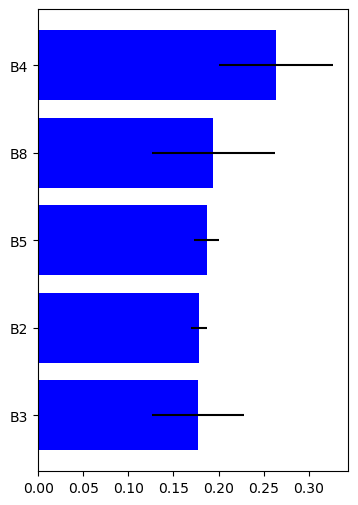

In [29]:
plt.rcParams["figure.figsize"] = (4,6)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

In [30]:
"""
Calling rasters/geotiffs using the pyspatial library/model

"""
yield1 = "Zim_final_image_100.tif"
yield2 = "Zim_final_image_200.tif"

yield2

'Zim_final_image_200.tif'

In [32]:
"""
This is the main ML model. You need to 
insert the values as generated by the tuning function

rf__max_depth: 100
	rf__max_features: 4
	rf__max_samples: 0.5
	rf__n_estimators: 1000
"""


rfReg = RandomForestRegressor(n_estimators=1000,max_features=4,max_depth=1000,max_samples=0.5,n_jobs=-1,random_state=24 , oob_score = True)
rfReg.fit(X_train, y_train);

In [35]:
"""
Calling RF model to check the outputs
"""

rfReg

RandomForestRegressor(max_depth=1000, max_features=4, max_samples=0.5,
                      n_estimators=1000, n_jobs=-1, oob_score=True,
                      random_state=24)

In [36]:
"""
Predicting the trained model on the geotiffs i.e multi spectral image and saving in file.
"""

predictors_rasters = [yield1]

stack = Raster(predictors_rasters)

result = stack.predict(estimator=rfReg, dtype='int16', nodata=-1)

result.write("Yield_Prediction_VERSION_2_OCT.tif")

Raster Object Containing 1 Layers
    attribute                                          values
0       names                                    [pred_raw_0]
1       files            [Yield_Prediction_VERSION_2_OCT.tif]
2        rows                                            7561
3        cols                                            8684
4         res  (0.0008983152841195215, 0.0008983152841195215)
5  nodatavals                                      [-32768.0]


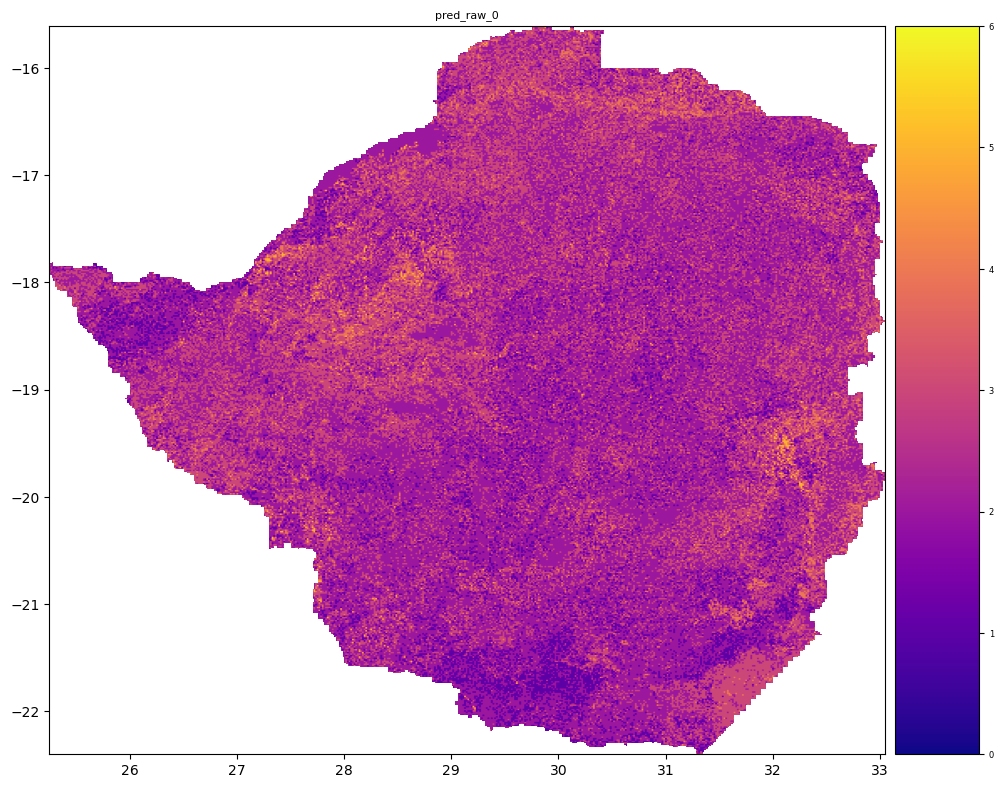

In [37]:
"""
Plotting the yield predcition output
"""

plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
result.plot()
plt.show()

## The first implementation estimates the yield of different crops based on the band values, while this one predicts/maps out the crop mask areas based on a column for different crops identified. The main difference, is while yield prediction uses Random forest regressor(Rreg), crop mask method uses random forest classifier(Rclas) method. Both models end up providing different outputs. ML engineer should understand what they want to achieve.

In [41]:
import geopandas as gpd

# Read the shapefile
# gdf = gpd.read_file("AUS_GEDI_UPDATED.shp")
gdf_2 = pd.read_csv("predicted_crop_type_data_extacted_2.csv")

# Print the first few rows of the GeoDataFrame
# print(gdf_2.tail())

gdf_2['yield'].unique()

array([4, 1, 2, 3])

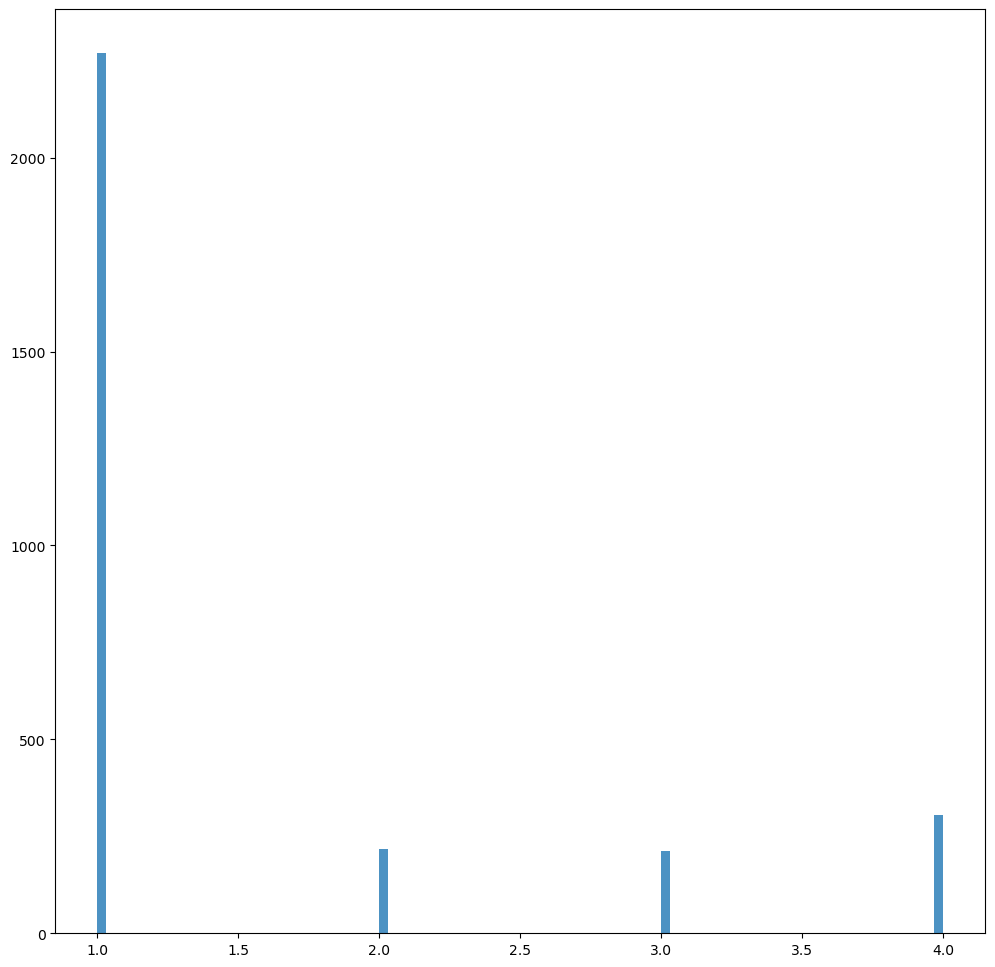

In [44]:
df2 = gdf_2
df2.head()
predictors2 =  df2
bins = np.linspace(min(predictors2['yield']),max(predictors2['yield']),100)
plt.hist((predictors2['yield']),bins,alpha=0.8);

In [45]:
X = predictors2.iloc[:,[0,1,2,3,4]].values
# Y = predictors['yield'].values
Y = predictors2.iloc[:,5:6].values
feat = predictors2.iloc[:,[0,1,2,3,4]].columns.values
feat
Y

array([[4],
       [4],
       [4],
       ...,
       [1],
       [1],
       [1]])

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=24)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)
y_test

array([1, 1, 1, ..., 2, 1, 1])

In [47]:
cf = RandomForestClassifier(random_state = 42)
cf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [48]:
rfclas = RandomForestClassifier(min_samples_leaf=40, oob_score=True)
rfclas.fit(X_train, Y_train);
dic_pred = {}
# dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['train']
dic_pred['test'] = rfReg.predict(X_test)
dic_pred['test']
pearsonr_all = [pearsonr(dic_pred['train'],Y_train)[1],pearsonr(dic_pred['test'],Y_test)[1]]
pearsonr_all

/var/folders/mf/0lb_7jld1p54p_x83sc_5r280000gn/T/ipykernel_75476/2524072168.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfclas.fit(X_train, Y_train);


[1.6479275493445155e-13, 0.0011638087543276944]

In [49]:
rfclas.oob_score_

0.7568287808127915

In [ ]:
pipeline = Pipeline([('rf',RandomForestClassifier())])

parameters = {
        'rf__max_features':(3,4,5),
        'rf__max_samples':(0.5,0.6,0.7),
        'rf__n_estimators':(500,1000),
        'rf__max_depth':(50,100,200,300)}

grid_search = GridSearchCV(pipeline,parameters,n_jobs=6,cv=5,scoring='r2',verbose=1)
grid_search.fit(X_train,y_train)


# rfReg = RandomForestClassifier(n_estimators=500,max_features=0.33,max_depth=500,max_samples=0.7,n_jobs=-1,random_state=24 , oob_score = True)
# rfReg.fit(X_train, y_train);
rfReg = RandomForestClassifier(n_estimators=500,max_features=0.33,max_depth=50,max_samples=0.5,n_jobs=-1,random_state=24 , oob_score = True)
rfReg
dic_pred = {}
dic_pred['train'] = rfReg.predict(X_train)
dic_pred['test'] = rfReg.predict(X_test)
pearsonr_all_tune = [pearsonr(dic_pred['train'],y_train)[0],pearsonr(dic_pred['test'],y_test)[0]]
pearsonr_all_tune

grid_search.best_score_


print ('Best Training score: %0.3f' % grid_search.best_score_)
print ('Optimal parameters:') 
best_par = grid_search.best_estimator_.get_params()
for par_name in sorted(parameters.keys()):
    print ('\t%s: %r' % (par_name, best_par[par_name]))

In [50]:
rfclas = RandomForestClassifier(n_estimators=500,max_features=0.33,max_depth=50,max_samples=0.5,n_jobs=-1,random_state=24 , oob_score = True)
rfclas.fit(X_train, y_train);
rfclas

RandomForestClassifier(max_depth=50, max_features=0.33, max_samples=0.5,
                       n_estimators=500, n_jobs=-1, oob_score=True,
                       random_state=24)

In [51]:
impt = [rfclas.feature_importances_, np.std([tree.feature_importances_ for tree in rfclas.estimators_],axis=1)]
ind = np.argsort(impt[0])
ind

array([3, 1, 2, 4, 0])

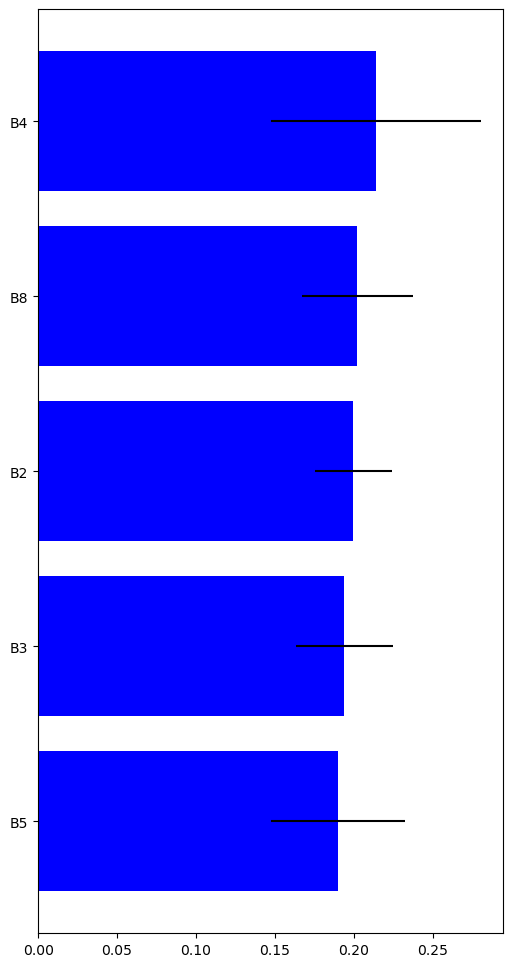

In [52]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(feat)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(feat)),feat[ind]);

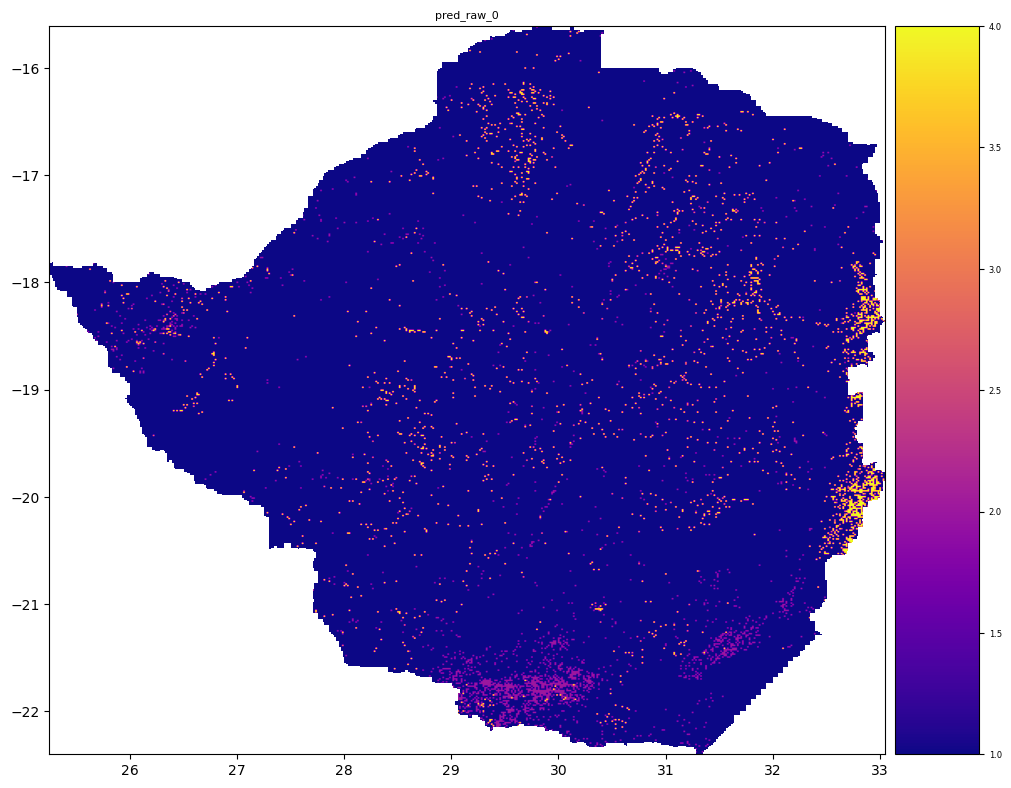

In [53]:
predictors_rasters = [yield1]

stack = Raster(predictors_rasters)

result2 = stack.predict(estimator=rfclas, dtype='int16', nodata=-1)


plt.rcParams["figure.figsize"] = (12,12)
result2.iloc[0].cmap = "plasma"
result2.plot()
plt.show()

In [54]:
type(result)
result.write("Crop_Mask_trial_2.tif",nodatavals=-1)

Raster Object Containing 1 Layers
    attribute                                          values
0       names                                    [pred_raw_0]
1       files                         [Crop_Mask_trial_2.tif]
2        rows                                            7561
3        cols                                            8684
4         res  (0.0008983152841195215, 0.0008983152841195215)
5  nodatavals                                      [-32768.0]
